<a href="https://colab.research.google.com/github/lucaslzl/search_ia_p1/blob/master/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Artificial Intelligence - MO416A**
**UNIVERSITY OF CAMPINAS**



This work was completed by the following members:



*   Aissa Hadj - 265189
*   Lucas Zanco Ladeira - 188951
*   Matheus Ferraroni - 212142
*   Maria Vitória Rodrigues Oliveira - 262884
*   Oscar Ciceri - 164786

The original code of the project is located on a [repository inside Github](https://github.com/lucaslzl/search_ia_p1) and the video showing the search strategies working is on [youtube](https://youtu.be/ffuthDRn6lE). 



In [0]:
from IPython.display import Image

![alt text](https://cdn02.nintendo-europe.com/media/images/10_share_images/games_15/nes_5/H2x1_NES_PacMan.jpg)

# **I - Introduction**




In this project, we choose to apply various search methods to the Pac-man game. Pac-man is a maze arcade game created in 1980 by Namco [[1]](https://en.wikipedia.org/wiki/Pac-Man). Pac-man is a character that must be placed in a maze that must collect pieces and find the exit (the goal) without being caught by moving ghosts. We set two objectives in this project. The first one aims to experiment with each one of the search methods in a practical way. Secondly, we want to determine which search algorithm, among the ones we selected, is best suited for the Pac-man game, according to the metrics and game conditions considered we will present shortly. 


The current report will be structured as follow. We will start by

1. presenting how we modeled the game, then
2. describing some of the most important components of our code implementation, 
3. giving the motivations for choosing the search methods we selected, 
4. showing the results found, and finally 
5. we will suggest which search method is best suited depending on the game conditions. 

We also wish to note here that the programming language for this project is Python version 3.8.


# **II - Problem modeling**



## **1 - General**

In order to implement the Pac-man game, we decided to do the following modelization. 

The main goal of the problem is to find a path that leads to the goal in order to solve the maze and finish the game. The second objective of Pac-man is to collect as many points as possible while progressing inside the maze.

We also defined a set of rules. First, Pac-man can move freely inside the white spaces in the maze. However, it can't go back and revisit already visited nodes. As with the original game, there are ghosts inside the map. For simplification, we make the assumption that the ghosts are static and thus can't move. The problem is therefore deterministic, we can fully determine the next state of the game given the current state as well as the action chosen by Pac-man. 

Under those conditions, Pac-man will reason about the solution before actually adopting it. That means that, even before the game starts, we execute any of the search methods to select a path from the starting position to the goal position. Once the search is complete, we provide a list of actions for Pac-man to follow in order to solve the maze. 

The other two important game conditions, whether there is a countdown (a time limit) for Pac-man to reach the goal, or Pac-man must collect the maximum number of points, will be discussed later in the report. Those two conditions will guide us in determining which search method is more appropriate by adopting either one of those constraints.

Below, we briefly discuss some of the most important elements of the problem.

**The maze:** In the game, there is a maze where Pac-man
has to collect as many pieces (we use the term "points" in this project) as possible without being caught by one of the ghosts. The maze is defined in
terms of a grid. The black-areas, in a Pac-Man game, are non-traversable walls. They are represented as a sequence of # symbols in the project. The pieces that Pac-man must collect in the maze are represented as "P" letters in our mazes. We also note that, under our game conditions, the ghosts present in the mazes are frozen. This means that they can't move and, for simplicity, we decided to replace them with walls. Pac-man can't go through them that way. Below is an example of a representation of a maze. When the game begins, Pac-man starts at the position described with the "S" letter and must finish the game by reaching the goal position ("G" letter in the maze). Below, we give more details about the implementation of the maze inside the file "map.py". We also wish to note that, in the project, we use the term "map" to designate the maze.

![alt text](https://github.com/lucaslzl/search_ia_p1/blob/master/maps/example%20of%20maze.png?raw=true)


**Actions:** In this game, there are in total 4 possible actions that Pac-man can choose: left, right, down, or up in that order. Depending on the position of Pac-man in the maze, there might be fewer actions allowed. For instance, if Pac-man reaches a wall, only sideway movements are allowed. 

**Nodes:** The nodes are composed by a state, a parent node, a path cost, a depth and a list of available actions. The node can be used to reconstruct the path used to achieve the goal and expand a node using the available actions.

**State:** The state is composed by the model of the scenario, points collected, points left, cost and information about the position of the actual state, start, goal, points and walls. The actual position, goal, start and points are represented as a pair of two coordinates (i, j) representing its row and column inside the map. The collected points is an integer and points left is a list of coordinates of these points. The state also control the positions on the a map that have never been visited and positions that have been already passed. The state is also responsable for check if the goal position has been achieved or not. The state check if a position on the map as already been visited, if it has the state does not return a valid action that allow a next state to go in that position, and this is used to avoid infinty loops.

**Note on the nodes explored:** During the execution of the search strategies it is possible to arrive at the same location on the map using different paths. Some strategies can used an approach to avoid expand nodes that have similar states, avoiding waste of memory and time.

Finally, in order to implement and evaluate the search methods for the problem described, we use the AIMA function library [2].


## **2 - Maps**




The map.py class has maze interaction functions, which will be described below. First, the init function receives the map file content, initializes the variables, and calls the validation function:

In [0]:
def __init__(self, map_text=None):
        self.map = None
        self.start = None
        self.goal = None
        self.pos = None
        self.points_pos = []
        self.points = 0
        self.cost_till_here = 0
        self.hashed = None

        if map_text!=None:
            self.validateMap(map_text)

The validate function verifies if the maze is valid, with walls on the sides, all the lines and colums with the same size and if it contains a start and a goal. Then, it saves the Goal and Point position in the map, and expresses these locations by 3 and 1, respectively. It sets up a "0" value where there is a barrier and "1" value where there is a space. Besides that, the start point (S) is described as "2".

It is important to notice that the walls and free positions on the maze are saved as matrix, the current position, start position and goal are saved as a set of coordinates and the points on the maze as a list of coordinates.

The script below exhibits this:

In [0]:
def validateMap(self, m):
        m = m.split("\n")

        for i in range(1,len(m),1):
            if len(m[i])!=len(m[0]):
                raise Exception("Map lines have different sizes.")

        i = 0
        j = 0

        self.map = []
        for line in m:
            j=0
            self.map.append([])
            for c in line:
                if ((i==0 or i==len(m)-1) and c!="#") or ((j==0 or j==len(m[i])-1) and c!="#"):
                    raise Exception("Maze borders must be '#'.")
                if c == "#":
                    self.map[i].append(0)
                elif c == " ":
                    self.map[i].append(1)
                elif c.upper() == "S":
                    if self.start!=None:
                        raise Exception("Only one Start is allowed.")
                    self.map[i].append(2)
                    self.start = [j,i]
                    self.pos = [j,i]
                elif c.upper() == "G":
                    if self.goal!=None:
                        raise Exception("Only one Goal is allowed.")
                    self.map[i].append(3)
                    self.goal = [j,i]
                elif c.upper() == "P":
                    self.map[i].append(1)
                    self.points_pos.append([j,i])
                else:
                    raise Exception("Invalid map char: "+c)

                j += 1
            i += 1

        if self.start==None or self.goal==None:
            raise Exception("Start and Goal must be provided")

Then, all the positions on the map are shown as integers as displayed below:

In [0]:
00000000000
01111111110
01000100010
01011111010
01010001010
01011311010
01000000010
01111211110
00000000000

There are also functions used to print the maze in a more human way, allowing the users to easily identify what is happening. This can be seen below:

In [0]:
def printVisual(self):
        for i in range(len(self.map)):
            for j in range(len(self.map[i])):
                c = None
                if self.map[i][j]==0:
                    c = "#"
                elif self.map[i][j]==1:
                    c = " "
                elif self.map[i][j]==2:
                    c = "S"
                elif self.map[i][j]==3:
                    c = "G"
                elif self.map[i][j]==4:
                    c = "$"

                for p in self.getPointsLeft():
                    if j==p[0] and i==p[1]:
                        c = "P"

                if i==self.pos[1] and j==self.pos[0]:
                    if self.pos!=self.start:
                        c = "X"
                print(c,end="")
            print("")

In the code below, it was verified the options of actions, depending on the self-position. If on the left/right/up/down there is no barrier and it was not a covered space, then it can be considered as a movement option.

The cgetActions function is used to get the valid actions to a state. It was designed to be as fast as possible and easy to understand. The algorithm just gets the current position and checks if an adjacent position is a wall or has been already visited. If these two statements are false, the action that leads to that position is valid. Otherwise the state does not return this position.

In [0]:
def getActions(self):
        ret1 = []
        ret2 = []        
        
        # LEFT
        val = self.map[self.pos[1]][self.pos[0]-1]
        if val!=0 and val!=4:
            ret1.append("E")
            ret2.append(1)
        
        # RIGHT
        val = self.map[self.pos[1]][self.pos[0]+1]
        if val!=0 and val!=4:
            ret1.append("D")
            ret2.append(2)
        # UP
        val = self.map[self.pos[1]+1][self.pos[0]]
        if val!=0 and val!=4:
            ret1.append("B")
            ret2.append(3)

        # DOWN
        val = self.map[self.pos[1]-1][self.pos[0]]
        if val!=0 and val!=4:
            ret1.append("C")
            ret2.append(4)

        return ret1, ret2

The act function alters the state by applying a valid action. The first step of the act is to check if the problem is solved. If it is already solved nothing is done. If it is not solved yet, the function verifies whether the next position is available. Then, the current position is marked with the number "4" (to show that this position has been visited), and the next position is marked as self-position. Besides that, the collectPoint function is called.

In [0]:
def act(self, action):

    if self.solved():
        print("Maze already completed.")
        return False

    if action==1 or action=="E": #moving left
        val = self.map[self.pos[1]][self.pos[0]-1]
        if val==0 or val==4: #check if is blocked or already passed
            return False
        self.map[self.pos[1]][self.pos[0]] = 4 # mark as passed
        self.pos = [self.pos[0]-1,self.pos[1]] # update position
        self.collectPoint(self.pos[1],self.pos[0])
        return True
    elif action==2 or action=="D": #moving right
        val = self.map[self.pos[1]][self.pos[0]+1]
        if val==0 or val==4:
            return False
        self.map[self.pos[1]][self.pos[0]] = 4
        self.pos = [self.pos[0]+1,self.pos[1]]
        self.collectPoint(self.pos[1],self.pos[0])
        return True
    elif action==3 or action=="B": #moving down
        val = self.map[self.pos[1]+1][self.pos[0]]
        if val==0 or val==4:
            return False
        self.map[self.pos[1]][self.pos[0]] = 4
        self.pos = [self.pos[0],self.pos[1]+1]
        self.collectPoint(self.pos[1],self.pos[0])
        return True
    elif action==4 or action=="C": #moving up
        val = self.map[self.pos[1]-1][self.pos[0]]
        if val==0 or val==4:
            return False
        self.map[self.pos[1]][self.pos[0]] = 4
        self.pos = [self.pos[0],self.pos[1]-1]
        self.collectPoint(self.pos[1],self.pos[0])
        return True

    raise Exception("Action unknown")

The collectpoint function verifies if the self-position is a Point (P) using the points_pos matrix. If it is, the state increments its points counter.

In [0]:
def collectPoint(self, i, j):
    ini = len(self.points_pos)
    self.points_pos = [a for a in self.points_pos if not(a[0]==j and a[1]==i)]
    if len(self.points_pos)!=ini:
        self.points += 1

The sim function returns a map object with the action applied. This is done in order to create new states faster, by copying the current state and just applying an action to it.

In [0]:
def sim(self, action): 
    ret = self.copy()
    ret.act(action)
    ret.cost_till_here = self.cost_till_here+1
    ret.hashed = None
    return ret

Finally, the solved function checks whether the self-position is the Goal (G).

In [0]:
def solved(self):
    return self.pos[0]==self.goal[0] and self.pos[1]==self.goal[1]

## **3 - Methodology for the search comparison**

**Maps:** To help us decide which search method is optimal in the Pac-man game, we will experiment with various conditions. We designed 9 different maps, classified under two groups. The first group is composed of 4 maps: map4, map10, map11, and map12. Those are empty maps. Meaning they contain no walls inside them. The second group is composed of 5 maps containing walls strategically placed to test the effectiveness of the approaches choosen.
The maps are of different sizes in length and width to see the effect of the maze size on each search method.

Besides, the maps contain 10 collectable points each. Some of the points may not be reachable following the rules applied in this project.

**Metrics:** The algorithms have been executed 10 times on each map in order to determine a good confidence interval. To compare the different search methods, we will measure the following metrics:


1. Time (sec, seconds): it's the execution time from start to finish of each search method to solve the maze
2. Nodes: it's the number of nodes generated by each search method
3. Expanded nodes: it's the number of nodes each search method explored to find a solution
4. Nodes per second (Nodes/sec): Number of nodes generated by second
5. Expanded nodes per second (Expanded nodes/sec): Number of nodes explored by second
6. Action: it's the total number of actions Pac-man has to take to go from the initial position to the goal
7. Points: it's the number of points Pac-man collected in its path to the goal

The metric "number of nodes" will help us measure the memory used by each search method to find a solution. A high number of generated nodes means a high use of memory.

The metric "nodes explored per second" can be used to determine how fast a search method selects a node to explore. A high number of nodes explored per second means that the search method can check more nodes in less time. This can change drastically if the search method is performing some kind of ordering to select the next node to explore.


With all those metrics measured during the simulations, we would then be able to compare the performance of each search method under different hypotheses.


We run the independent experiments all at once (using the script located inside "execute.sh") inside a single machine. It's a MacBook Air containing a 1.6 GHz Intel Core I5, and 8 Gb of RAM. To prevent any skewing of the results, we closed all other applications, so that no other script was running in parallel while conducting the experiments.

# **III - Search Methods Considered**






In this problem, we selected the following search methods: 



1. Breadth-first search
2. Depth-first search
3. A*1
4. A*2
5. Local beam search
6. Hill climbing

Below we describe each one of them, explain why they were chosen for this project, as well as showing the script implemented in Python. 

## **1 - Breadth-first search**

For the performance measures, we consider $b$ the average number of successors and $d$ shallowest depth of the solution.

Breadth-first Search
This strategy has the capability to search in a graph-like (graph or tree) data structure. The distance from a node to the starting node is used to explore the data. The key idea is that it may not explore a node of a farther distance without exploring every node from the same distance. A queue structure is usually utilized as the First In First Out (FIFO) rule is followed.

**Performance measures:**

**Completeness**: Yes, this strategy is classified as complete as it finds the goal if it exists.

**Optimization:** Yes, only if all the paths have the same cost.

**Time complexity:** $ O(b^d) $

**Memory complexity:** $ O(b^d) $

Below we provide the implementation of the breadth-first search in Python.

In [0]:
def BreadthFirst(problem):

    checkeds = []
    frontier = deque([Node(problem.initial)])

    while frontier:

        node = frontier.popleft()

        if problem.goal_test(node.state):
            return node

        frontier.extend(node.expand(problem))

    return None

## **2 - Depth-first search**

This strategy has the capability to search in a graph-like data structure. The distance from a node to the starting node is used to explore the data. The key idea is that it will explore a node with a farther distance without exploring any other node from the same distance if possible. A stack structure is usually utilized as the Last In First Out (LIFO) rule is followed.

**Performance measures:**

**Completeness:** No, it may create an infinite loop if a branch has no end.

**Optimization:** No, there is no guarantee that will find the best solution even if all paths have the same cost.

**Time complexity:** $ O(b^d) $

**Memory complexity:** $ O(bd) $

Below we provide the implementation of the depth-first search in Python.

In [0]:
def DepthFirst(problem):

    frontier = [Node(problem.initial)]

    while frontier:

        node = frontier.pop()

        if problem.goal_test(node.state):
            return node

        frontier.extend(node.expand(problem))

    return None

## **3 - A-Star**

### **Strategy**

This solution employs the best-first graph search or greedy search, thus the node expansions are given by the lowest scores first policy.

This policy sorts the nodes, employs a mechanism that minimizes the function f(n). For example, the breadth-first search occurs when f(n)=node.depth.

Moreover, the function f(n) "memorizes" the nodes previously computed, in order to examine the f values and recover the path.

The following code shows the implementation of the best-first graph search:

In [0]:
def best_first_graph_search(problem, f, display=False):
    # Nodes in cache
    f = memoize(f, 'f') 
    node = Node(problem.initial)
    # Priority queue giving by the lowest score in f(n)=g(n)+h(n)
    frontier = PriorityQueue('min', f)
    # Initial node
    frontier.append(node)
    explored = set()
    # While node goal different goal state
    while frontier:
        node = frontier.pop()
        # If node goal equal node state, return node
        if problem.goal_test(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node
        # else, add node to the priority queue
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None

def Astar(problem, display=False):
    h = None
    h = memoize(h or problem.h, 'h')
    fn = n.path_cost + h(n)
    
    return best_first_graph_search(problem, lambda n: fn, display)

The A-Star strategy tries to expand the node, which is closest to the goal and also considers the cost to reach that node. This expansion policy means that the f function depends on two values.

Thus, the evaluation of the nodes is done employing the function f(n):

f(n) = g(n) + h(n)

- g(n): cost to reach each node
- h(n): cost to get from the node to the goal

In this project, the function g(n) is equal to the path cost.

The path cost of this solution increases by a value of 1 when the state changes by an action.

Thus, the cost is uniform for every step in the path, since all steps have the same value.

In [0]:
def path_cost(self, c, state1, action, state2):
        return c + 1

Also, the node evaluation is given by a heuristic h(n), which assumes that the node closest to the goal is the fastest solution.

The following sections show the two heuristics employed in this project.

### **A-Star 1**

The A*1 heuristic employs the Euclidean distance, which calculates the straight line distance in a Cartesian plane.

Thus, h1(n) is calculated as:

In [0]:
def h1(self, node):
    return node.state.getDistance()
    
def getDistance(self):
    v = distance.euclidean(self.pos, self.goal)
    return v

The A Search is complete and optimal when the function h(n) satisfies the following conditions:

Consistent heuristic:$$h(n) \leq  c(n, a, n') + h(n')$$

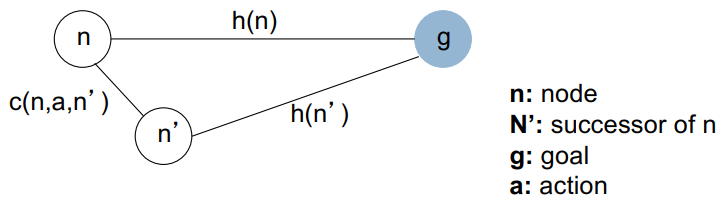

In [0]:
Image("https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/img/consistent.png", width=500, height=200)

In this case, the steps between the actual free space and the goal space can never be longer than the Euclidean distance.

If

- h(n) = Euclidean distance from node n to goal g

- h(n') : Euclidean distance from node n' to goal g

- c(n, a, n') = 1

This heuristic, which employs the Euclidean distance, is a consistent heuristic due to in the best case when the actions to go from n to n' decreases the path in 1 step. We have that the c(n, a, n') + h(n') is equal to h(n).

### **A-Star 2**

The A*2 heuristic employs the Euclidean distance combined with a distance to reach a near point.

Thus, h2(n) is calculated as:

If

- a = Euclidean distance from node n to goal g
- b = Euclidean distance from node n to the nearest point p
- c = Euclidean distance that point p to the goal g
- v = b + c

As shown the following figure:

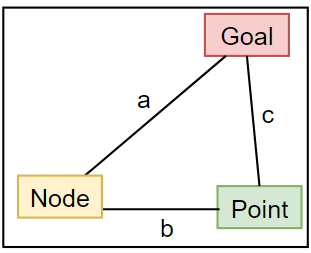

In [0]:
Image("https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/img/h2.png", width=300, height=300)

The heuristic considers v, as the Euclidian distance to go from the node n to the point and after to the goal. These distances satisfy the following inequality:

$$ a \leq b + c$$ 
$$ a \leq v $$

However, the distance c is mapped to a smaller value equal to a, with the aim that the node considers the point and that the heuristic is consistent.

The steps to calculate h2 are explained below.

Find the distance from the node n to the nearest point p (distance b). Subsequently, calculate the distance from that point p to the goal g (distance c).
If there are no more points on the map, it employs the Euclidian distance between the node n and the goal g (distance a), equal to h1.
Calculate x as the division between a and v. The value of x is a number between 0 to 1 since a is always less or equal to c. Thus, when the node is closer to the point, the x value will approach 1.

$$ x = \frac{a}{v} = \frac{a}{b+c}: 0 < x \leq 1 $$

Calculate the complement of x a in order to penalize the distance c. Thus a higher the distance to c, the value of x will approach 1.
$$ x' = 1 - x $$
Finally, we consider x value as a percentage of c. The heuristic is consistent the calculated value need to be higher than c; then we add c to the percentage previously calculated as:
$$ h_2 = c + c\cdot(1-x): c < h_2 < 2 \cdot c$$

In [0]:
def h2(self, node):
    return node.state.getDistancePoints()

def getDistancePoints(self):
    points = self.getPointsLeft()
    # print(points)
    dis_Pos_Goal = distance.euclidean(self.pos, self.goal)
    dis_Pos_Point = distance.euclidean(self.pos, self.goal)
    dis_Point_Goal = 0
    valeu = 0
    x = 0.0

    if(len(points)==0):
        valeu =  dis_Pos_Goal
    else:
        # Find the distance of the closest point
        for ip in points:
            if distance.euclidean(self.pos, ip) < dis_Pos_Point:
                dis_Pos_Point = distance.euclidean(self.pos, ip)
                dis_Point_Goal = distance.euclidean(ip, self.goal)
        
        # Calculate v
        v = dis_Pos_Point + dis_Point_Goal
        if dis_Pos_Point == 1:
            v=0
        if(v>0):
            x = dis_Pos_Goal/v
        else:
            x = 1
        # Calculate h2
        valeu = dis_Pos_Goal + dis_Pos_Goal*(1-x)
    return valeu

## **5 - Local Beam Search**

One of the methods adopted to solve the Pac-man game is the local beam search. It's an algorithm that keeps track of k states. 

The main objective is to find the goal, and, if the goal isn't found yet, to collect as many points along the path to the goal as possible. 

Since the local beam search grabs k good neighbor states without thinking ahead about where to go next, this algorithm is greedy. In fact, it tries to increase the objective function defined as the number of collected points (the optimization problem). Under this method, the path to the goal is irrelevant. 

The way the search method works is that it selects the k best successors according to the number of points they contain. During the search, only k states are kept in memory every time we expand new nodes. This method is particularly suitable for devices with very limited memory. 

If collecting as many points as possible is important, the local beam search method is an appropriate algorithm for this problem.

The steps for this algorithm are the following:


1.   We begin with k randomly generated states,
2.   All the successors of all the k states are generated,
1.   If any of the successors is the goal, the algorithm stops
2.   Else we select the k best successors from the complete list of successors ranked by the number of points each node contains, and 
1.   We repeat the process from step 2

An important hypothesis we make is that before starting the local beam search, we have no detail about the map, its size, structure, or any other information that could give a clue about the maze. 

Also, since the number of possibilities can quickly get high as we progress inside the map, we set a value of 10 for the width. We select the 10 best successors at each time during the search. We choose k = 10 for two reasons. First, we select the best nodes from where to collect points, while having a reasonable chance of finding the goal. If after the search ends, it doesn't find a solution, we increase the value of k by 5 and start a new search from the initial position "S". This process continues until the search either finds a solution or k reaches the maximum value of 5010 (at this value, there is reasonable confidence we explored the entire map without finding the goal, provided the map is dense and hasn't a too large size). 


Again, the local beam search is selected, in this problem, to maximize the objective function which is the number of points collected. By design, during each step, the search selects the k best immediate neighbors of the k current states. The ranking is made according to the number of points each successor contains. Thus, theoretically, we expect that the local beam search will give good results, among all the search methods implemented in the problem, if we consider only the number of points collected.

From another perspective, if we imagine a map with points concentrated in a region of the map opposite to the goal, then the search will naturally progress to the region containing those points before heading back to the goal state. As a result, the solution path, according to the local beam search, would end up being longer than the one found by other methods (especially information searches using the Euclidean distance from the current node to the goal state).

Since only k nodes are expanded when exploring the map, the path to the goal could be discarded (the unique path to the goal contains no points to collect for instance). Thus, there is no guarantee to find a solution with a given value of k, and therefore the local beam search isn't complete. To solve that issue in the context of the current problem, we start a new search by increasing the value of k until either all of the nodes are explored or we reach a solution. By increasing each time the value of k, we increase the number of successors kept in memory at each step of the process. Thus, the local beam search becomes more and more like the breadth-first search method.  


**Completeness:** No, this strategy doesn't guarantee it will find a solution, if a solution exists.

**Optimization:** No, this strategy doesn't guarantee it will find the optimal solution (finding the path that collects the maximum number of points possible under the game conditions)

**Time complexity:**  $ O(k*d) $ 

**Memory complexity:**  $ O(k*d) $

Below we provide the implementation of the local beam search in Python.

In [0]:
def local_beam_search(problem, k_width):
    """
    From the initial node, Select randomly k states,
    From all the successors, select the k neighbors with highest value,
    Stopping when goal is found or no more successor
    Else repeat process
    """
    current = Node(problem.initial)

    if k_width >= len(current.expand(problem)):
      k_successors = current.expand(problem)
    else:
      k_successors = random.sample(current.expand(problem), k=k_width)

    #check if there are successors to the k successors selected
    if not k_successors:
        return None

    explored = set()
    goal_found = False

    while goal_found == False:
      all_successors = []

      #Generate the successors of all the k best states
      for successor in k_successors:
        children = successor.expand(problem)
        for child in children:
          if child.state not in explored and child not in all_successors:
            all_successors.append(child)

      #if there is no successor, we stop
      if not all_successors:
        #print("No solution found with width =", k_width)
        break

      #check if any successor is a goal
      for successor in all_successors:
        if problem.goal_test(successor.state):
          goal_found = True
          #print("Solution found for width =", k_width)
          return successor

      #Select the k best successors
      all_successors.sort(key=lambda node: node.state.getPoints(), reverse=True)
      k_successors = all_successors[:k_width]

      #Mark the k successors as explored, to avoid exploring same nodes
      for successor in k_successors:
        explored.add(successor.state)

    return None

## **5 - Hill Climbing**


Hill climbing uses a heuristic to define which is the best node at a given state to expand. In our approach, we use the Euclidian distance and select the node with the smaller value.

**Completeness:** No

**Optimization:** No

**Time complexity:** $ O(b^d)$

**Memory complexity:** uses few memory

Below we provide the implementation of the local beam search in Python.

In [0]:
def argmin_random_tie(seq, key=identity):
    return min(shuffled(seq), key=key)

def shuffled(iterable):
    items = list(iterable)
    random.shuffle(items)
    return items

def hill_climbing(problem):
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmin_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        current = neighbor
        if current.state.solved():
            break 
    return current

# **IV - Results**

### **Simulation Results and Discussion**

The figures presented in this section show the mean values derived from 10 independent replications and a confidence intervals of 95%.
We compared the strategies in terms of:
- Simulated time
- Number of generated nodes
- Number of points won
- Number of points left
- Number of actions from the initial position to the goal
- Number of expanded nodes
- Number of nodes generated nodes per second
- Number of expanded nodes per second

These metrics were observed into dense and non-dense scenarios. For the sake of clearness, the confidence intervals are omitted, and we analyze only the scenarios with points. The rest of the results (with 0 point scenarios) have similar values.


#### **Simulated time**
The simulation results show that the computing time is lower for the DFS and Hill because those search methods aim to reach the depth node in the queue. Those mechanisms produce  slightly  lower  delay  values  in non-dense scenarios. They provide a computing time two or three orders of magnitude lower than the others strategies. Moreover, the A*1 search method produces similar values to the DFS and Hill searches in high empty maps (scenarios 11 and 12) because this method aims to find the goal following the Euclidean distance, which is the shortest path. This means that this strategy is similar to DFS in this type of maps.

In general, the time increases exponentially with the size of the map. We can find the reason by looking at the graph measuring the nodes per second, and expanded nodes per second. As the map increases in size, those metrics decrease dramatically. The difference between the different search methods  according  to the complexity, type and number of operation(s), every time new nodes are expanded, get even more obvious with increasing map size.

<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_times.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_times.png'></td></tr></table>


The local beam search has a relatively average execution time compared to the other methods. In the case of non-dense maps (empty maps), the number of successors increases exponentially (to the order of 3 to the n, in the middle of the maze, far from the walls), when we increase the map size (map size is the same for map 4 and 10, only the distribution of points is different). For the map 11 and 12, the time increased much dramatically. In fact, for those two maps, an iteration over the width k was necessary to find a solution (k=50 for map 11 and k=285 for map12). Incrementing the value of k by 5 on each iteration, from an initial value of 10, until reaching an optimal value of k=50 for map 11 and k=285 for map 12, slowed down the local beam search method. We can note here that it is difficult to choose a "good" value for k, map 11 and 12 have the same size, only their structure is different, but the difference in value of the search width is of the order of almost 6.  

On the other hand, BFS produce a computation time of 4 second on average for non-dense and dense scenarios. This occurs because the BFS prioritizes the length of the map and not the depth. For most maps, the starting position and the goal position are in opposite side; thus BFS processes all possible paths until reaching the goal.


### **Number of actions**

The Simulation results show that the depth-first search method produces a higher number of actions than the other strategies, for both dense and non-dense scenarios. Those values occur because the search expands the shallowest node, which requires more steps to reach the goal position and also requires a higher computing time, as shown previously.

We notice that the local beam search finds a path that is systematically longer than the others found by other methods, except for the depth-first search. Also, the path to the goal, found by the local beam search, increases with the size of the map. Those results confirm our initial expectations. The local beam search is mainly concerned in maximizing its objective function (collecting the maximum number of points).  Moreover, the other strategies produce similar values.

<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_acti.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_acti.png'></td></tr></table>



### **Number of generated nodes**

This metric comprehends the amount of generated nodes. Generated nodes are nodes that were checked by the strategy and loaded to memory. Thus, the number of nodes measures the total memory used to perform each search method by counting the total number of nodes kept during the search to find a solution.

The Simulation results show that the Hill and BFS search methods produce a lower number of nodes generated in both scenarios.  This occurs because Hill expands the node only to find a better solution.  If the change produces a new change to produce a better solution, another incremental change is made to the new solution, repeating this process until no improvement can be found, which considerably reduces the memory size. Moreover, the DFS produces low memory consumption due to its expansion of nodes in depth. On the other hand, the LBS  selects k best successors every time new nodes are expanded, the memory required by this search is bounded by the width k. As a consequence, for both dense and empty maps, the local beam search required an average memory size compared to the other methods for finding a solution. The only exception to that is for map 11 and 12. Much bigger values of k (50 and 285 respectively), and as a consequence a much higher memory, were necessary to find a solution. Since those maps are empty, the number of new successors, when new nodes are expanded, from which to select a set of k best successors increases exponentially to the order of 3 to the N inside the map. For values of k below 50 and 285, for the maps 11 and 12, the lists of nodes selected are trapped in the bottom half of the map.

<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_nodes.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_nodes.png'></td></tr></table>


### **Number of points win**

As mentioned before, one of the objectives is to collect as many points as possible on the map. Therefore, the graphics below present the results of this metric. It describes the average number of points collected by each search method over increasing sizes of the map. As expected, the local beam search is very efficient at collecting points on average (5.8 points collected). It surpasses the other search methods on this metric, for maps that are relatively dense in terms of walls inside it. However, as the map gets bigger, the average number of points collected decreases. In fact, with increasing size, while keeping the total number of points available to collect constant (10 points), the number of nodes expanded gets much bigger, it becomes less probable to find points inside the expanded nodes. Especially if the points are dispersed over the map. In non-dense scenarios, the DFS presents the best results, with an average of 5.0 points collected. Besides, in both approaches, the Hill strategy presents the worst result, averaging 0.2 points collected


<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_pont.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_pont.png'></td></tr></table>

The simulation results show that the points left metric (not collected in the path) experiences opposite behavior to the points won metric (figures not shows in this report). In addition, the DFS and LBS strategies present the best result again in dense and non-dense scenarios.

### **Number of expanded nodes**

The simulation results show that the BFS and Hill search methods expand on average  30 and 10  nodes, non-dense scenarios, respectively. These values are two or three order of magnitudes lower than the other strategies, such as BFS, which expand on average 30000 nodes.  In the worst case scenario (map 2), BFS expanded 100000 nodes.

<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_expa.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_expa.png'></td></tr></table>

However, this expansion node metric is subjective to the performance evaluation because some methods expand the nodes faster. For example, A*2 expands the same number of nodes as BFS  in the scenario; however, the time to expand the nodes is lower (being  800 per second and 5000 nodes) for A*2 and BFS respectively, as shown in the following figures.

<table><tr><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/dense_expanded_per_sec.png'></td><td><img src='https://raw.githubusercontent.com/lucaslzl/search_ia_p1/master/plots/with_points/nodense_expanded_per_sec.png'></td></tr></table>

### **Maps with no points:**

We won't discuss the results of the local beam search on maps with no points to collect. Given the objective of this method and the way it is implemented, discussing its results with the objective function set to 0 over the map makes no sense.


# **V - Conclusion**

In most cases, the Hill search method finds a solution with the lowest cost in terms of time and number of actions to reach the goal from the starting position. However, for non-dense maps, the BFS produces similar values to the Hill search method. Moreover, LBS finds a solution only if we set a large value of the width k. This means that the search wasted time finding a solution with previously lower values of k. It is possible to find "rules" to select an appropriate width range for "k". However, this wouldn't have been an "elegant" implementation for this algorithm and more importantly we don't have any information about the map initially. We preferred, in this problem, to adopt the most simpler option, incrementing the value of k until the local beam search finds a solution.

Finally, for more complex problems in general, when adopting LBS, we could keep in memory the number of possibilities at each time we expand new successors. If we don't find a solution the first time we run the algorithm, that memorized number could help us select an adequate value of the next width to increase the probability of finding a solution.

# **VII - Sources**

[1] https://en.wikipedia.org/wiki/Pac-Man

[2] https://github.com/aimacode/aima-python/blob/master/search.ipynb

# **Appendix**

## **Link to the Github repository**

[https://github.com/lucaslzl/search_ia_p1](https://github.com/lucaslzl/search_ia_p1)

## **Link to the video**

https://www.youtube.com/watch?v=ffuthDRn6lE&feature=youtu.be

## **How to execute the files**

There are two ways to execute the experiments:

**1. Execute the python code called "main.py" and pass the parameters**

The code considers the parameters to execute each strategy and map. It is possible to change how many times it executes and to print or not the results.

Run "python3 main.py --(strategy flag)" to execute.

For instance, "python main.py --bfs --maps=./maps/map1.txt,./maps/map2.txt" executes both files with bfs.

It is worth to point out that you may run "python main.py --help" to visualize all the possible flags and parameters.

To see the state after applying each action add the tag "--print"

**2. Execute the shellcode called "execute.sh"**

The code executes every strategy in each map 10 times and saves the results. Besides, a code called "compute.py" read all outputs and calculate distinct metrics.

run "./execute.sh" and wait until it is done.

All results are saved in the results folder as the "computer.py" code.

Good idea to use virtual env. Tested on Python 3.8